In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display

sns.set(font_scale=1.5)

In [294]:
def parse_file(df, path, group, file):
    full_path = path + '/' + file
    known_lb = 0
    known_ub = 0
    negative_weight = 0
    collected = {}
    with open(full_path, 'r') as f:
        for line in f:
            key, value = line.split(':')

            if key.startswith('Known lower'):
                known_lb = int(value)
                continue
            if key.startswith('Known upper'):
                known_ub = int(value)
                continue
            if key.startswith('Negative'):
                negative_weight = int(value)
                continue

            algo = ''
            if key.startswith('Brute'):
                algo = 'bruteforce'
            elif key.startswith('Rand'):
                algo = 'random'
            elif key.startswith('Greed'):
                algo = 'greed'
            elif key.startswith('Goemans'):
                algo = 'goemans-williamson'

            if algo not in collected:
                collected[algo] = [0, 0]

            if key.endswith('(answer)'):
                collected[algo][0] = int(value)
                known_lb = max(known_lb, int(value))
            else:
                collected[algo][1] = float(value)
    for algo, (ans, time) in collected.items():
        group_name = group
        if 'biqmac' in group:
            group_name = group + '/' + file[:-2]
        df.loc[len(df)] = [
            group_name, algo, ans, time, known_lb, known_ub, negative_weight, file[:-2]
        ]


def parse_results(path='../testing/results'):
    df = pd.DataFrame(columns=[
        'group', 'algo', 'weight', 'time', 'known_lower_bound',
        'known_upper_bound', 'negative_weight', 'filename'
    ])
    for root, dirs, files in os.walk(path):
        if not files:
            continue
        dir_name = root.split('results/')[-1]
        for file in files:
            parse_file(df, root, dir_name, file)
    return df


def add_solutions(df, solutions_file):
    with open(solutions_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line != '':
                file, ans = line.split(' ')
                ans = int(ans)
                ind = df[df['filename'] == file].index
                df.loc[ind, 'known_lower_bound'] = ans

In [340]:
def accumulate_results(all_results):
    df = pd.DataFrame(columns=[
        'group', 'algo', 'mean_time', 'mean_accuracy_lb', 'mean_accuracy_ub'
    ])
    for group_name, group_results in all_results.groupby('group'):
        for algo_name, table in group_results.groupby('algo'):
            df.loc[len(df)] = [
                group_name, algo_name,
                table.time.mean(),
                table.accuracy_lb.mean(),
                table.accuracy_ub.mean()
            ]
    return df

In [337]:
all_results = parse_results()
all_results.head()

,group,algo,weight,time,known_lower_bound,known_upper_bound,negative_weight,filename
0,random_graph_50/size-8,bruteforce,8,0.00044,8,10,0,rand-12
1,random_graph_50/size-8,random,8,0.00007,8,10,0,rand-12
2,random_graph_50/size-8,greed,7,0.00000,8,10,0,rand-12
3,random_graph_50/size-8,goemans-williamson,7,0.02957,8,10,0,rand-12
4,random_graph_50/size-8,bruteforce,14,0.00049,14,20,0,rand-79


In [338]:
add_solutions(all_results, '../testing/tests/biqmac/solutions/ising.txt')
add_solutions(all_results, '../testing/tests/biqmac/solutions/rudy.txt')

In [339]:
all_results['accuracy_lb'] = \
    (all_results['weight'] - all_results['negative_weight']) / \
        (all_results['known_lower_bound'] - all_results['negative_weight'])
all_results['accuracy_ub'] = \
    all_results['weight'] / all_results['known_upper_bound']

In [341]:
results = accumulate_results(all_results)
results.head()

,group,algo,mean_time,mean_accuracy_lb,mean_accuracy_ub
0,biqmac/ising/ising2.5-100_5555,goemans-williamson,0.27099,0.993725,0.354846
1,biqmac/ising/ising2.5-100_5555,greed,0.00061,0.993900,0.355094
2,biqmac/ising/ising2.5-100_6666,goemans-williamson,0.39158,0.993726,0.344382
3,biqmac/ising/ising2.5-100_6666,greed,0.00053,0.995010,0.346923
4,biqmac/ising/ising2.5-100_7777,goemans-williamson,0.35093,0.977962,0.379060


In [329]:
def plot_stats_in_group(df, name_filter, param, title=None, 
                        xlabel=None, ylabel=None, xlim=None, ylim=None,
                        add_theoretical_est=False):
    with sns.axes_style('darkgrid'):
        plt.figure(figsize=(15, 6))
        sns.lineplot(data=df,
                     x=df['group'].apply(name_filter),
                     y=df[param].astype(np.float),
                     hue='algo',
                     alpha=0.7)
        if add_theoretical_est:
            xmin = df['group'].apply(name_filter).min()
            xmax = df['group'].apply(name_filter).max()
            plt.hlines(0.87856, xmin=xmin, xmax=xmax,
                      linestyle='--', color='black',
                      alpha=0.7, 
                       label=r'Теоретическая оценка $88\%$')
            plt.legend()
        plt.xlim(xlim)
        plt.ylim(ylim)
        if title is not None:
            plt.title(title)
        if xlabel is not None:
            plt.xlabel(xlabel)
        if ylabel is not None:
            plt.ylabel(ylabel)

In [216]:
def plot_accuracy(df, name_filter, title=None, 
                        xlabel=None, ylabel=None, xlim=None, ylim=None):
    with sns.axes_style('whitegrid'):
        plt.figure(figsize=(15, 10))
        all_x = df['group'].apply(name_filter)
        x_min = all_x.min()
        x_max = all_x.max()
        for algo in df.algo.unique():
            data = []
            x = df[df['algo'] == algo]['group'].apply(name_filter)
            y_min = df[df['algo'] == algo]['mean_accuracy_lb']
            y_max = df[df['algo'] == algo]['mean_accuracy_ub']
            data = list(zip(x, y_min, y_max))
            data.sort(key=lambda x: x[0])
            x = list([d[0] for d in data])
            y_min = list([d[1] for d in data])
            y_max = list([d[2] for d in data])
            
            plt.fill_between(x, y_min, y_max, label=algo, alpha=0.4)
        
        plt.hlines(0.87856, xmin=x_min, xmax=x_max, linestyle='--', 
                 label=r'Теоретическая оценка $88\%$')
        
        
        plt.xlim(xlim)
        plt.ylim(ylim)
        
        plt.legend(loc='lower left')
        if title is not None:
            plt.title(title)
        if xlabel is not None:
            plt.xlabel(xlabel)
        if ylabel is not None:
            plt.ylabel(ylabel)

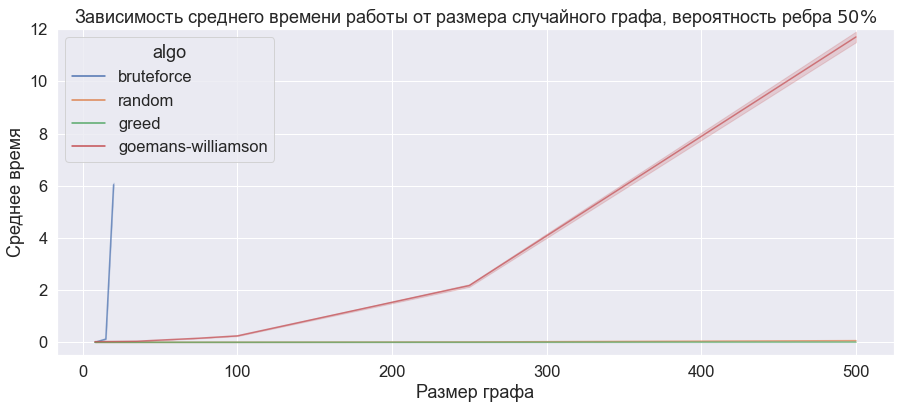

In [277]:
plot_stats_in_group(all_results[all_results['group'].str.contains('random_graph_50')],
                    lambda x: int(x.split('/')[-1].split('-')[-1]),
                    'time',
                    title='Зависимость среднего времени работы '
                    'от размера случайного графа, '
                    r'вероятность ребра $50\%$',
                    xlabel='Размер графа',
                    ylabel='Среднее время',
                    ylim=(-0.5, 12))

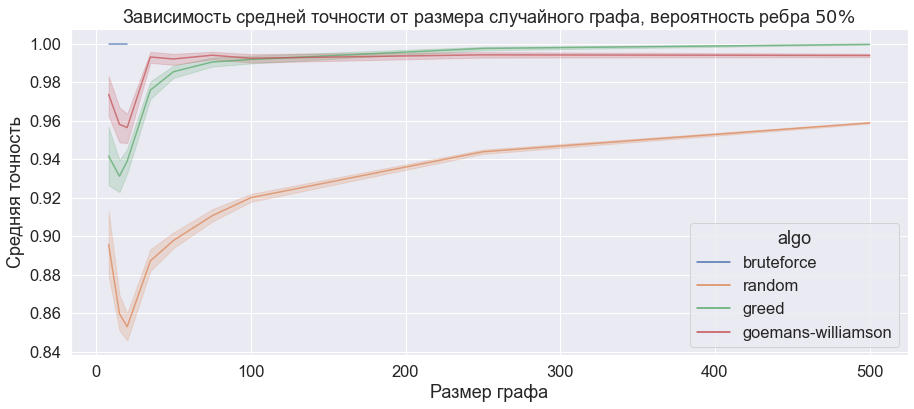

In [276]:
plot_stats_in_group(all_results[all_results['group'].str.contains('random_graph_50')],
                    lambda x: int(x.split('/')[-1].split('-')[-1]),
                    'accuracy_lb',
                    title='Зависимость средней точности '
                    'от размера случайного графа, '
                    r'вероятность ребра $50\%$',
                    xlabel='Размер графа',
                    ylabel='Средняя точность')

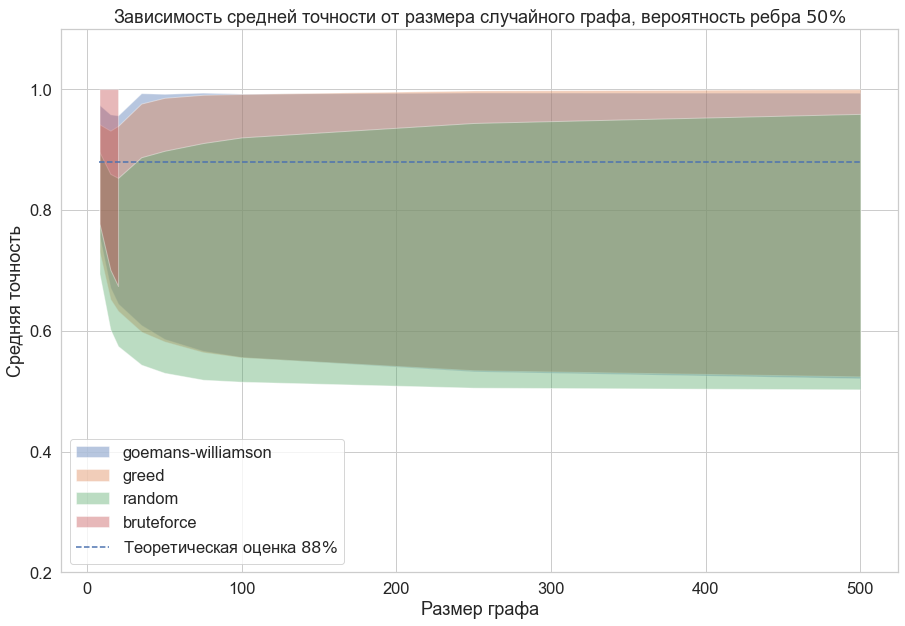

In [279]:
plot_accuracy(results[results['group'].str.contains('random_graph_50')],
                    lambda x: int(x.split('/')[-1].split('-')[-1]),
                    title='Зависимость средней точности '
                    'от размера случайного графа, '
                    r'вероятность ребра $50\%$',
                    xlabel='Размер графа',
                    ylabel='Средняя точность',
                    ylim=(0.2, 1.1))

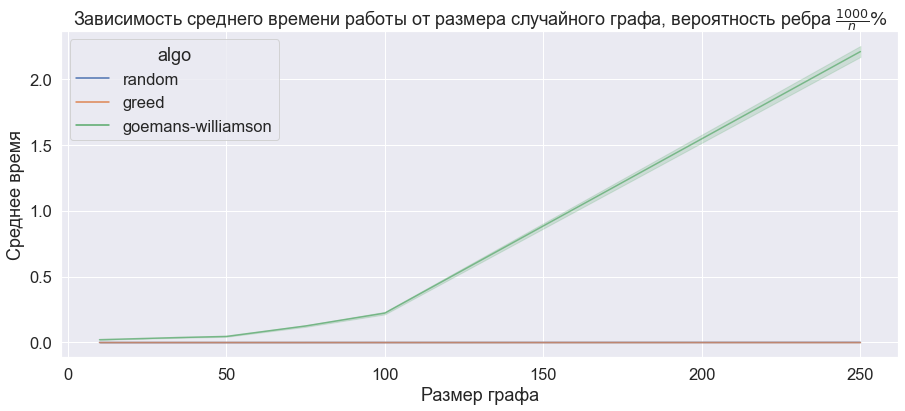

In [281]:
plot_stats_in_group(all_results[all_results['group'].str.contains('random_graph_10n')],
                    lambda x: int(x.split('/')[-1].split('-')[-1]),
                    'time',
                    title='Зависимость среднего времени работы '
                    'от размера случайного графа, '
                    r'вероятность ребра $\frac{1000}{n}\%$',
                    xlabel='Размер графа',
                    ylabel='Среднее время')

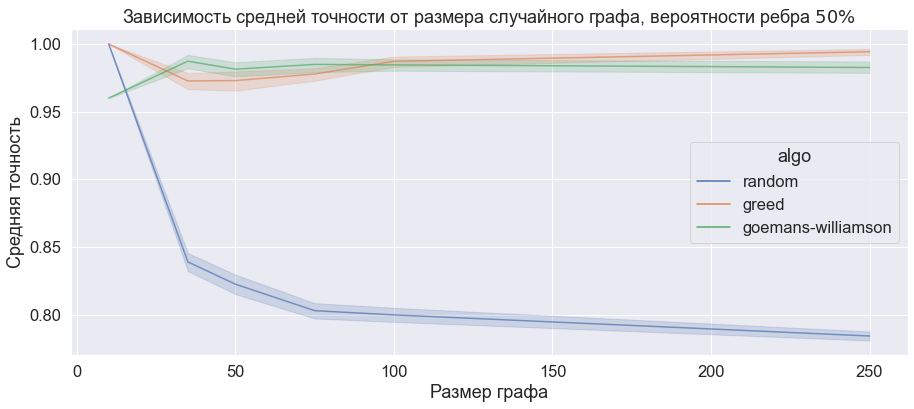

In [286]:
plot_stats_in_group(all_results[all_results['group'].str.contains('random_graph_10n')],
                    lambda x: int(x.split('/')[-1].split('-')[-1]),
                    'accuracy_lb',
                    title='Зависимость средней точности '
                    'от размера случайного графа, '
                    r'вероятности ребра $50\%$',
                    xlabel='Размер графа',
                    ylabel='Средняя точность')

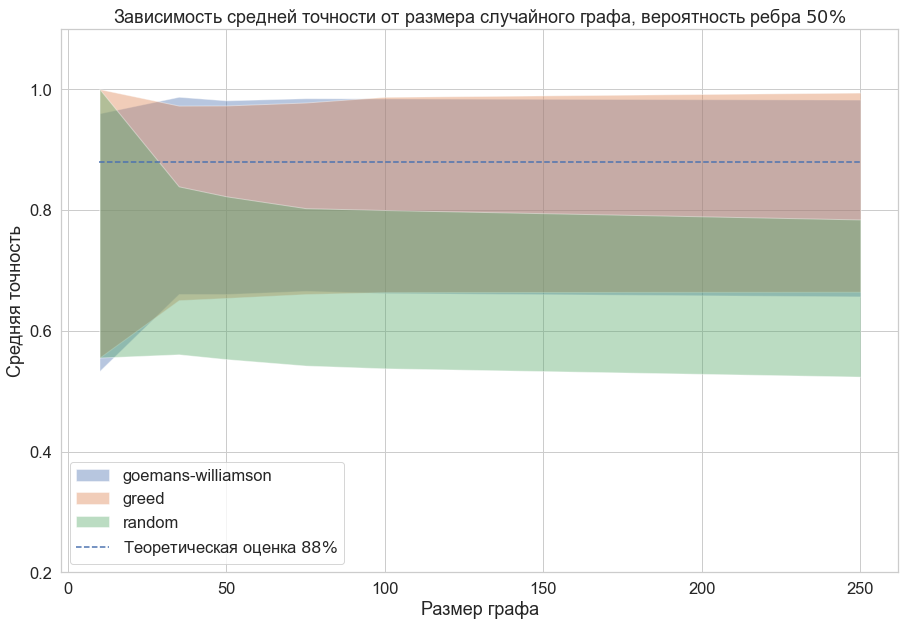

In [219]:
plot_accuracy(results[results['group'].str.contains('random_graph_10n')],
                    lambda x: int(x.split('/')[-1].split('-')[-1]),
                    title='Зависимость средней точности '
                    'от размера случайного графа, '
                    r'вероятность ребра $50\%$',
                    xlabel='Размер графа',
                   ylabel='Средняя точность',
                    ylim=(0.2, 1.1))

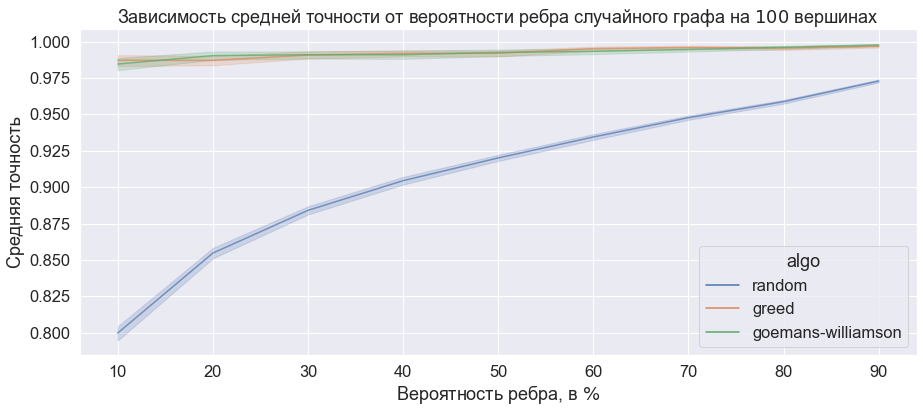

In [284]:
plot_stats_in_group(all_results[all_results['group'].str.contains('random_graph_prob')],
                    lambda x: int(x.split('/')[-1].split('-')[-1]),
                    'accuracy_lb',
                    title='Зависимость средней точности '
                    'от вероятности ребра случайного графа '
                    r'на $100$ вершинах',
                    xlabel=r'Вероятность ребра, в $\%$',
                    ylabel='Средняя точность')

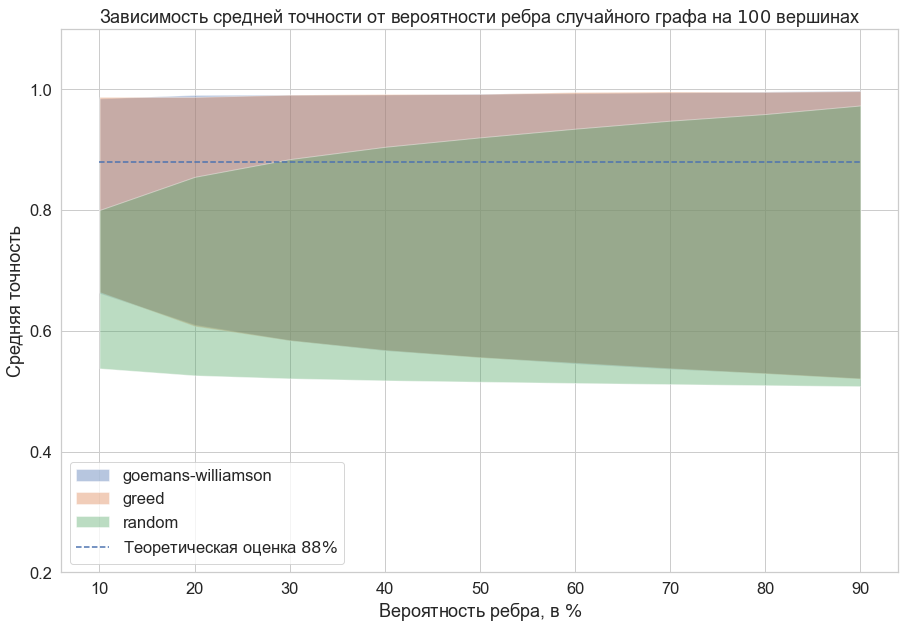

In [285]:
plot_accuracy(results[results['group'].str.contains('random_graph_prob')],
                    lambda x: int(x.split('/')[-1].split('-')[-1]),
                    title='Зависимость средней точности '
                    'от вероятности ребра случайного графа '
                    r'на $100$ вершинах',
                    xlabel=r'Вероятность ребра, в $\%$',
                   ylabel='Средняя точность',
                    ylim=(0.2, 1.1))

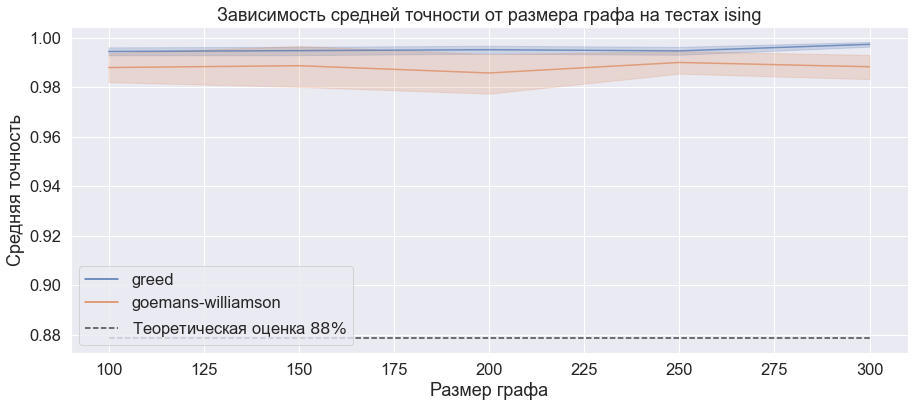

In [330]:
plot_stats_in_group(all_results[all_results['group'].str.contains('biqmac/ising/ising')],
                    lambda x: int(x.split('/')[-1].split('-')[-1].split('_')[0]),
                    'accuracy_lb',
                    title='Зависимость средней точности '
                    'от размера графа '
                    r'на тестах ising',
                    xlabel=r'Размер графа',
                    ylabel='Средняя точность',
                    add_theoretical_est=True)

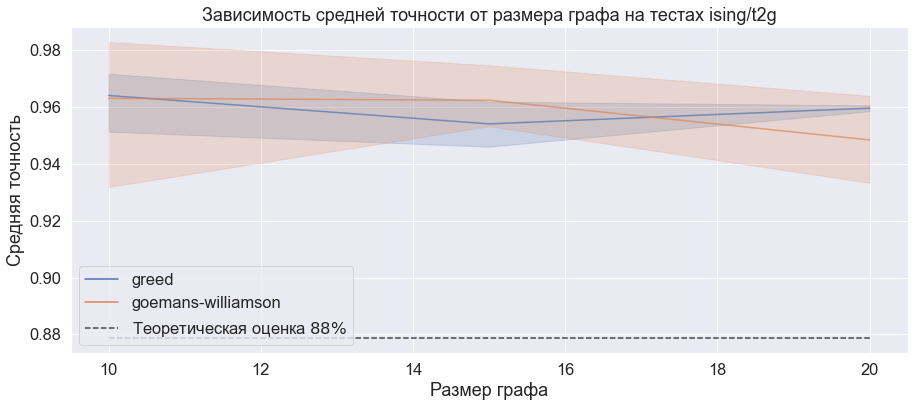

In [331]:
plot_stats_in_group(all_results[all_results['group'].str.contains('biqmac/ising/t2g')],
                    lambda x: int(x.split('/')[-1].split('_')[0].split('g')[1]),
                    'accuracy_lb',
                    title='Зависимость средней точности '
                    'от размера графа '
                    r'на тестах ising/t2g',
                    xlabel=r'Размер графа',
                    ylabel='Средняя точность',
                    add_theoretical_est=True)

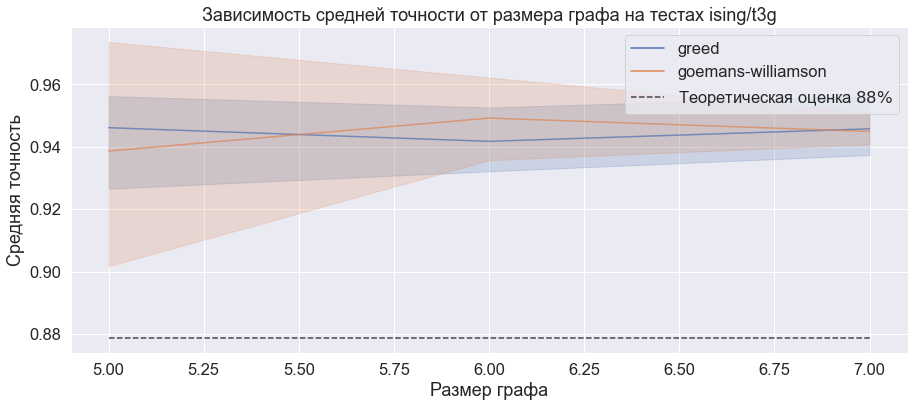

In [332]:
plot_stats_in_group(all_results[all_results['group'].str.contains('biqmac/ising/t3g')],
                    lambda x: int(x.split('/')[-1].split('_')[0].split('g')[1]),
                    'accuracy_lb',
                    title='Зависимость средней точности '
                    'от размера графа '
                    r'на тестах ising/t3g',
                    xlabel=r'Размер графа',
                    ylabel='Средняя точность',
                    add_theoretical_est=True)

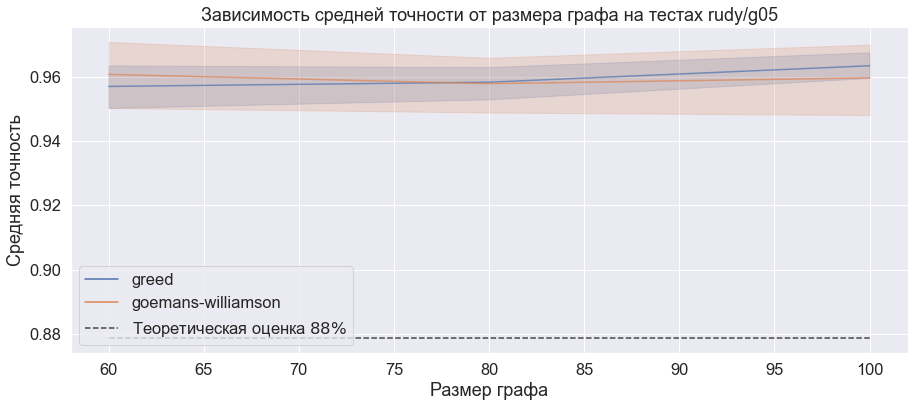

In [333]:
plot_stats_in_group(all_results[all_results['group'].str.contains('biqmac/rudy/g05')],
                    lambda x: int(x.split('/')[-1].split('_')[1].split('.')[0]),
                    'accuracy_lb',
                    title='Зависимость средней точности '
                    'от размера графа '
                    r'на тестах rudy/g05',
                    xlabel=r'Размер графа',
                    ylabel='Средняя точность',
                    add_theoretical_est=True)

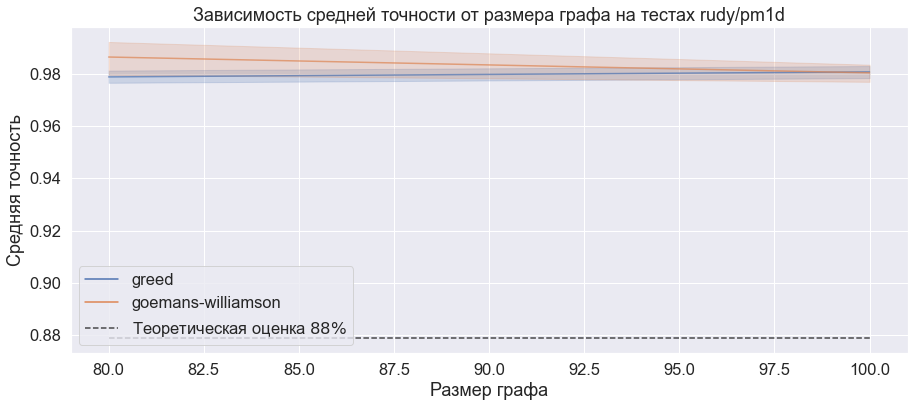

In [334]:
plot_stats_in_group(all_results[all_results['group'].str.contains('biqmac/rudy/pm1d')],
                    lambda x: int(x.split('/')[-1].split('_')[1].split('.')[0]),
                    'accuracy_lb',
                    title='Зависимость средней точности '
                    'от размера графа '
                    r'на тестах rudy/pm1d',
                    xlabel=r'Размер графа',
                    ylabel='Средняя точность',
                    add_theoretical_est=True)

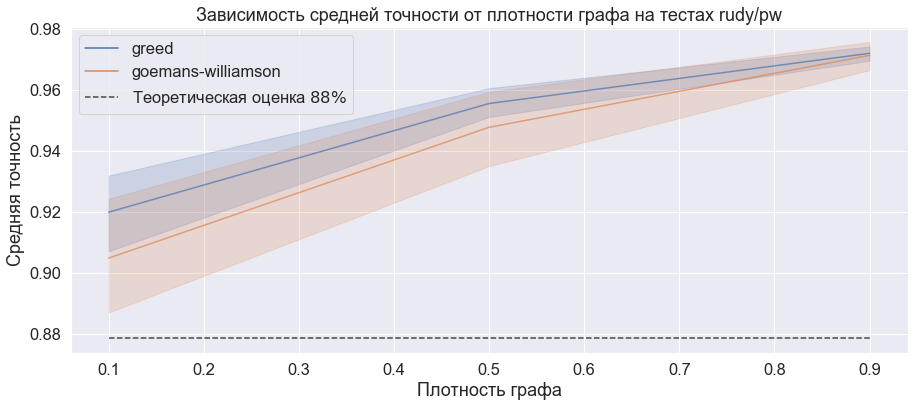

In [335]:
plot_stats_in_group(all_results[all_results['group'].str.contains('biqmac/rudy/pw')],
                    lambda x: int(x.split('/')[-1].split('_')[0].split('w')[1])/10,
                    'accuracy_lb',
                    title='Зависимость средней точности '
                    'от плотности графа '
                    r'на тестах rudy/pw',
                    xlabel=r'Плотность графа',
                    ylabel='Средняя точность',
                    add_theoretical_est=True)

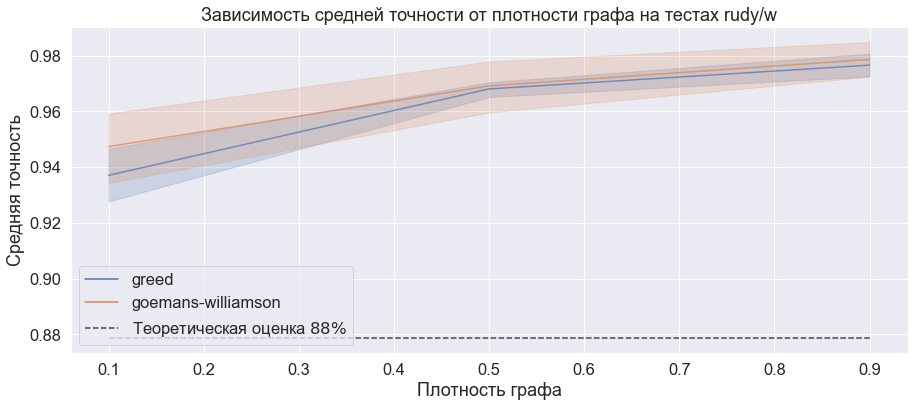

In [336]:
plot_stats_in_group(all_results[all_results['group'].str.contains('biqmac/rudy/w')],
                    lambda x: int(x.split('/')[-1].split('_')[0].split('w')[1])/10,
                    'accuracy_lb',
                    title='Зависимость средней точности '
                    'от плотности графа '
                    r'на тестах rudy/w',
                    xlabel=r'Плотность графа',
                    ylabel='Средняя точность',
                    add_theoretical_est=True)

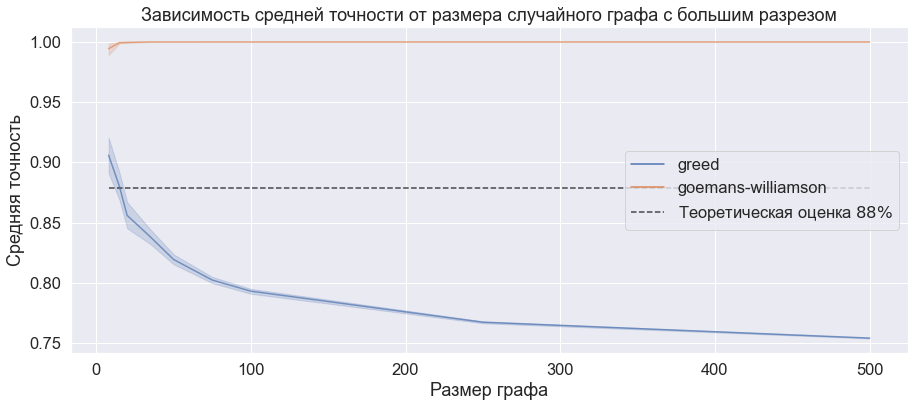

In [343]:
plot_stats_in_group(all_results[all_results['group'].str.contains('large_cut')],
                    lambda x: int(x.split('/')[-1].split('-')[-1]),
                    'accuracy_lb',
                    title='Зависимость средней точности '
                    'от размера случайного графа '
                    r'с большим разрезом',
                    xlabel='Размер графа',
                    ylabel='Средняя точность',
                    add_theoretical_est=True)